In [1]:
%matplotlib inline

Copied/adapted this notebook from: <a href=http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py> PyTorch: Training a Classifier on CIFAR-10</a>
Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CBAS-36 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CBAS-36

Using ``torchvision``, it’s extremely easy to load CBAS-36.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])

trainset = torchvision.datasets.ImageFolder(root='images/cbas34_train', transform=transform)

# # get index for curriculum sampling
# id2idx = {}
# for i,img in enumerate(trainset.imgs):
#     img_id_str = img[0].split('/')[4].split('.')[0]
#     id2idx[img_id_str] = i

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)

testset = torchvision.datasets.ImageFolder(root='images/cbas34_val', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = trainset.classes

Let us show some of the training images, for fun.



knife truck bench donut


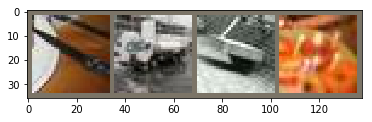

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(tensor):
    for t, m, s in zip(tensor, IMAGENET_MEAN, IMAGENET_STD):
            t.mul_(s).add_(m)     # unnormalize
    npimg = tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



<img src=https://www.researchgate.net/profile/Vladimir_Golovko3/publication/313808170/figure/fig4/AS:552880910368768@1508828489761/Architecture-of-simplified-convolutional-neural-network.ppm>

In [5]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 34)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


net = LeNet()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
from size_curriculum import size_train
size_train(trainset, net, criterion, optimizer, np.arange(-2.5, 1, 0.5))

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


Process Process-3:
Process Process-2:
Process Process-1:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib

KeyboardInterrupt: 

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 3.507
[1,  4000] loss: 3.334
[1,  6000] loss: 3.259
[1,  8000] loss: 3.160
[1, 10000] loss: 3.103
[1, 12000] loss: 3.059
[2,  2000] loss: 3.000
[2,  4000] loss: 2.988
[2,  6000] loss: 2.977
[2,  8000] loss: 2.962
[2, 10000] loss: 2.941
[2, 12000] loss: 2.929
[3,  2000] loss: 2.877
[3,  4000] loss: 2.876
[3,  6000] loss: 2.884
[3,  8000] loss: 2.879
[3, 10000] loss: 2.870
[3, 12000] loss: 2.881
[4,  2000] loss: 2.821
[4,  4000] loss: 2.818
[4,  6000] loss: 2.818
[4,  8000] loss: 2.818
[4, 10000] loss: 2.819
[4, 12000] loss: 2.817
[5,  2000] loss: 2.721
[5,  4000] loss: 2.759
[5,  6000] loss: 2.768
[5,  8000] loss: 2.775
[5, 10000] loss: 2.786
[5, 12000] loss: 2.779
[6,  2000] loss: 2.698
[6,  4000] loss: 2.695
[6,  6000] loss: 2.744
[6,  8000] loss: 2.722
[6, 10000] loss: 2.751
[6, 12000] loss: 2.757
[7,  2000] loss: 2.661
[7,  4000] loss: 2.683
[7,  6000] loss: 2.714
[7,  8000] loss: 2.702
[7, 10000] loss: 2.704
[7, 12000] loss: 2.701
[8,  2000] loss: 2.627
[8,  4000] 

5. Test the network on the test data

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
outputs = net(Variable(images))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 3744 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 2.7% accuracy (randomly picking
a class out of 36 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct = list(0. for i in range(34))
class_total = list(0. for i in range(34))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(34):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor on to the GPU, you transfer the neural
net onto the GPU.
This will recursively go over all modules and convert their parameters and
buffers to CUDA tensors:

.. code:: python

    net.cuda()


Remember that you will have to send the inputs and targets at every step
to the GPU too:

::

        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.
